### Goal
- prepare stats data for machine learning

### Steps
- : review dtypes,and prepare continuous numeric, discrete numeric, categorical, character and identity columns
Input: nfl_weekly_stats.parquet
Work:
    - separate continuous numeric, discrete numeric, categorical, character and identity columns
    - label encode
    - merge all back together
Output:
    - nfl_ml_weekly_stats.parquet - cleaned, labeled data

In [1]:
import os
import sys
sys.path.append(os.path.abspath("../src"))


In [2]:
from src import *


Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


In [3]:
logger = configs.configure_logging("pbp_logger")
logger.setLevel(logging.INFO)

#### load stats data

In [4]:

input_file_name = "nfl_weekly_defense"
power_column = "defense_power"

data_directory = get_config('data_directory')
input_path = os.path.join(data_directory,  f"{input_file_name}.parquet")
assert  os.path.exists(input_path)

original_stats_df = pd.read_parquet(input_path)
original_stats_df.head()

,team,season,week,receiving_fumbles_lost,receiving_fumbles,sack_fumbles,sack_yards,sacks,ps_interceptions,sack_fumbles_lost,...,tackle,qb_hit,team_score,team_coach,opposing_team,opposing_score,opposing_coach,spread,count,win
index,,,,,,,,,,,,,,,,,,,,,
0,ARI,2016,1,0.0,0.0,0.0,19.0,3.0,0.0,0.0,...,68.0,4.0,21,Bruce Arians,NE,23,Bill Belichick,-2.0,1,loss
1,ARI,2016,2,0.0,0.0,0.0,4.0,1.0,0.0,0.0,...,63.0,8.0,40,Bruce Arians,TB,7,Dirk Koetter,33.0,1,win
2,ARI,2016,3,0.0,0.0,2.0,27.0,5.0,4.0,0.0,...,73.0,6.0,18,Bruce Arians,BUF,33,Rex Ryan,-15.0,1,loss
3,ARI,2016,4,0.0,0.0,1.0,23.0,3.0,3.0,1.0,...,52.0,3.0,13,Bruce Arians,LA,17,Jeff Fisher,-4.0,1,loss
4,ARI,2016,5,0.0,0.0,0.0,8.0,1.0,0.0,0.0,...,78.0,9.0,33,Bruce Arians,SF,21,Chip Kelly,12.0,1,win


#### drop columns we don't need

In [5]:
from src.build_power_scores import prepare_power_data

features_df = prepare_power_data(original_stats_df)


2023-07-18 06:38:52,165 - INFO - encode the target win/loss column
2023-07-18 06:38:52,166 - INFO - create a features dataframe for feature selection ...
2023-07-18 06:38:52,167 - INFO - scale all features  ...


#### scale numeric data for ml feature selection

#### review correlations

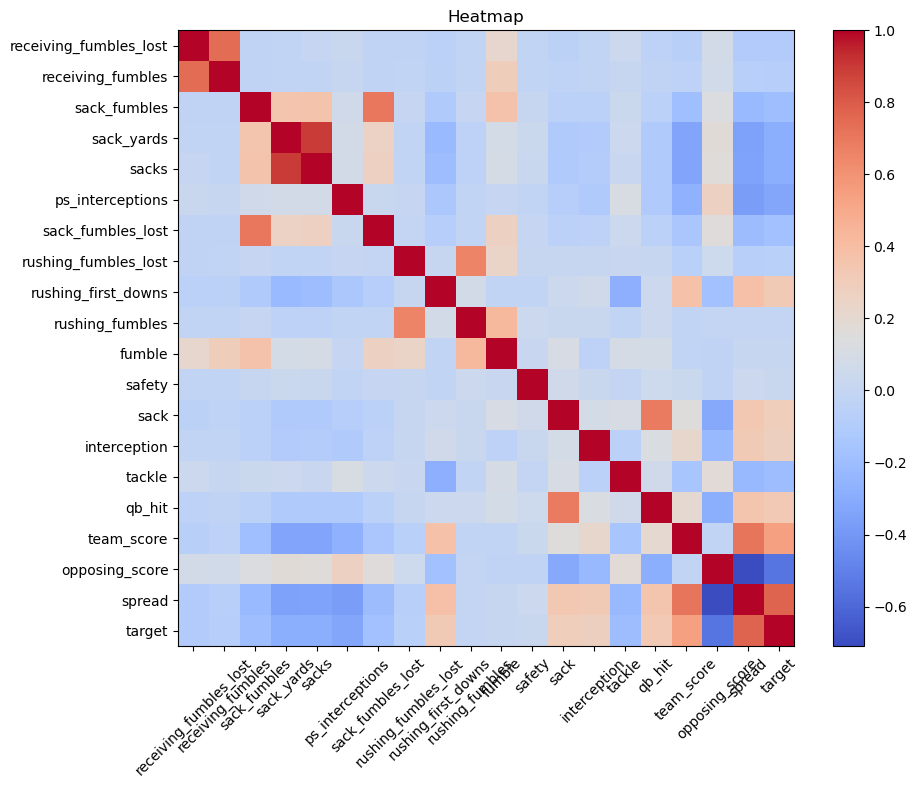

In [6]:
from src.utils_eda import plot_heatmap

# Create heatmap using plt.imshow()
numeric_df = original_stats_df.select_dtypes(include='number').drop(columns=['season', 'week',  'count'])
plot_heatmap(original_stats_df, drop_columns=['season', 'week',  'count'])

### best correlations to target

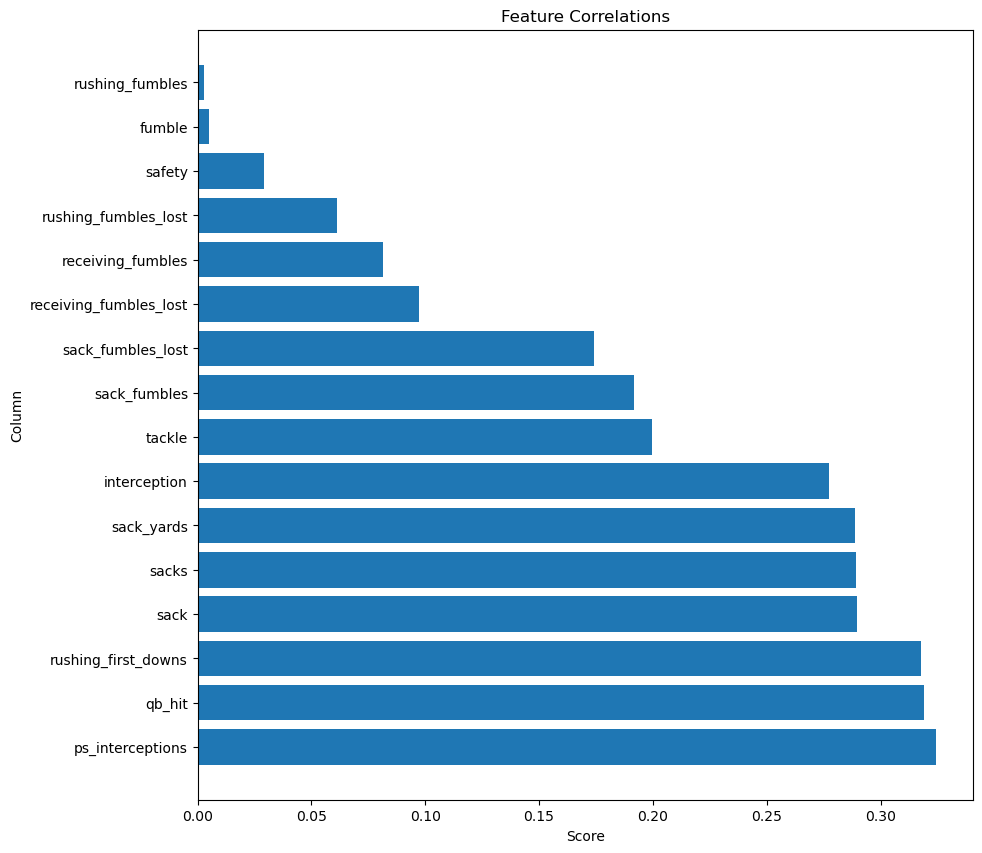

In [7]:
from src.utils_eda import correlate_to_target, plot_correlations

top_correlations, set_correlations = correlate_to_target(features_df, 'target', 30)
plot_correlations(top_correlations['corr'], top_correlations['y'], 'Feature Correlations')


### train xgboost feature model

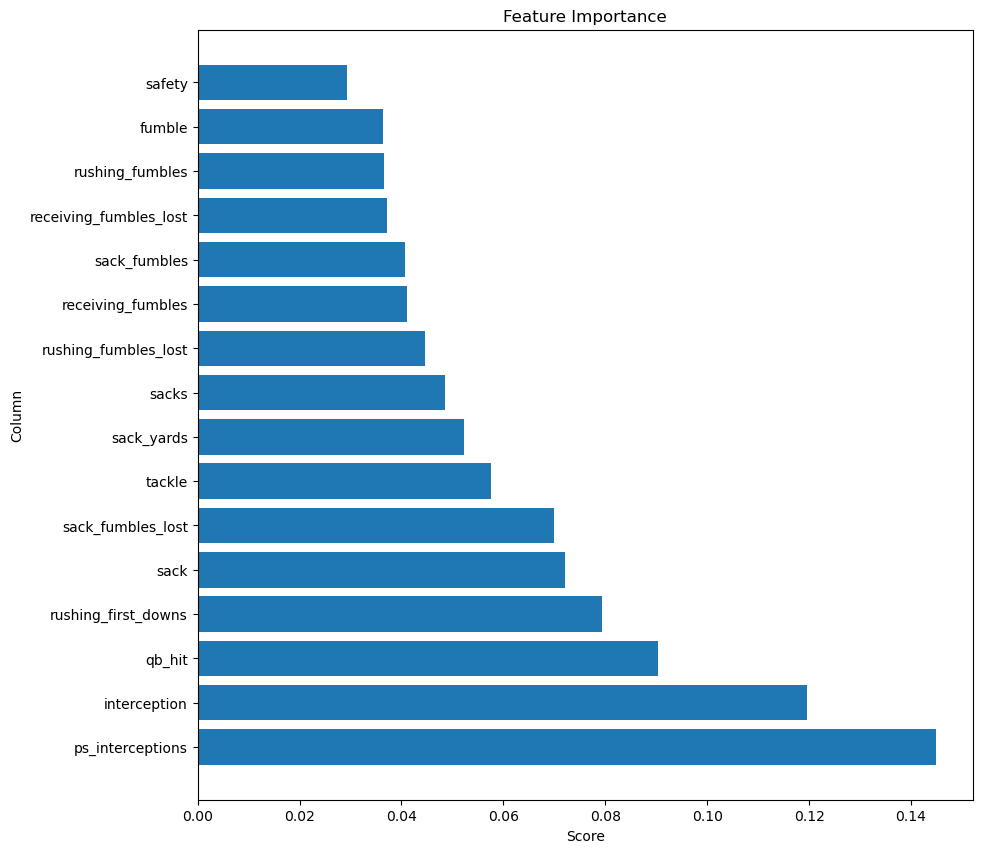

In [8]:
from src.utils_eda import calc_feature_importance

y = features_df.pop('target')

top_features, set_features = calc_feature_importance(features_df, y, top_n=30)
plot_correlations(top_features['corr'], top_features['y'], "Feature Importance")

### concat a weighted average "power" score to the stats dataset

In [9]:
from src.build_power_scores import concat_power_score

concat_power_score(df=original_stats_df, summary_data=top_features, threshold=.01, power_column=power_column)
original_stats_df.head()

2023-07-18 06:38:53,668 - INFO - get percentage contribution of offensive and defensive features
2023-07-18 06:38:53,672 - INFO - calculate weighted average of offensive and defensive features


,team,season,week,receiving_fumbles_lost,receiving_fumbles,sack_fumbles,sack_yards,sacks,ps_interceptions,sack_fumbles_lost,...,team_score,team_coach,opposing_team,opposing_score,opposing_coach,spread,count,win,target,defense_power
index,,,,,,,,,,,,,,,,,,,,,
0,ARI,2016,1,0.0,0.0,0.0,19.0,3.0,0.0,0.0,...,21,Bruce Arians,NE,23,Bill Belichick,-2.0,1,loss,0,6.173816
1,ARI,2016,2,0.0,0.0,0.0,4.0,1.0,0.0,0.0,...,40,Bruce Arians,TB,7,Dirk Koetter,33.0,1,win,1,5.540982
2,ARI,2016,3,0.0,0.0,2.0,27.0,5.0,4.0,0.0,...,18,Bruce Arians,BUF,33,Rex Ryan,-15.0,1,loss,0,8.111671
3,ARI,2016,4,0.0,0.0,1.0,23.0,3.0,3.0,1.0,...,13,Bruce Arians,LA,17,Jeff Fisher,-4.0,1,loss,0,5.962334
4,ARI,2016,5,0.0,0.0,0.0,8.0,1.0,0.0,0.0,...,33,Bruce Arians,SF,21,Chip Kelly,12.0,1,win,1,7.655234


#### sanity check the power score

In [10]:
X = original_stats_df[[ power_column ]]
y = original_stats_df[[ 'target']]


In [11]:
from src.build_power_scores import create_shallow_model

model, callbacks = create_shallow_model(X)

r = model.fit(X, y, epochs=200, batch_size=64, verbose=0, validation_split=0.2, callbacks=callbacks)

2023-07-18 06:38:53.699736: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1 Pro
2023-07-18 06:38:53.699758: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2023-07-18 06:38:53.699761: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2023-07-18 06:38:53.700121: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:303] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-07-18 06:38:53.700431: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:269] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2023-07-18 06:38:54.307700: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-07-18 06:38:55.534739:

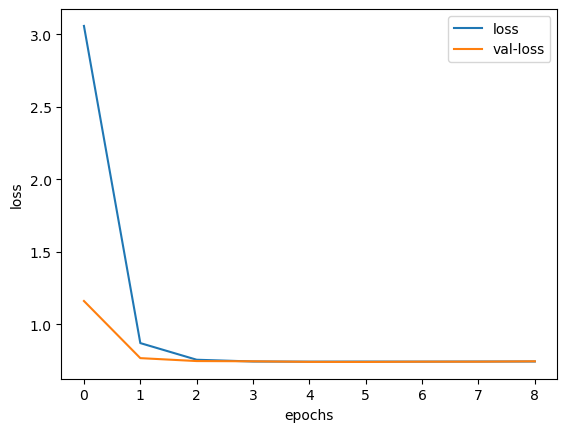

In [12]:
from src.utils_eda import plot_loss

plot_loss(r)

### save the dataset

In [13]:
%%time

data_directory = get_config('data_directory')
if not os.path.exists(data_directory):
    os.makedirs(data_directory)

output_path = os.path.join(data_directory, f"{input_file_name}_ml.parquet")
original_stats_df.to_parquet(output_path, engine='fastparquet', compression='snappy')

CPU times: user 98.7 ms, sys: 5.71 ms, total: 104 ms
Wall time: 39.8 ms
